In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa
from pathlib import Path
import os, shutil
plt.ion()

In [2]:
from audiomentations import Compose, AddGaussianNoise, PitchShift, Normalize, FrequencyMask
import numpy as np
import soundfile as sf
import librosa

In [3]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [4]:
path = r"C:\Users\feder\Desktop\DSIM\DSIM_project\monodimensionale\v2-final\data\data_final\Alces_alces\01.wav"

In [11]:
augm_04 = Compose([
    FrequencyMask(min_frequency_band=0.1,max_frequency_band=0.2,p=1)
])

In [5]:
def augmentation(path, augment):
    y, sr = librosa.load(path)
    augmented_samples = augment(samples=y, sample_rate=sr)
    return augmented_samples, sr

In [6]:
def get_waveform(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, audio_binary

In [27]:
frame_length = 2048
frame_step = 512
num_mel_bins = 75
num_spectrogram_bins = (frame_length // 2) + 1
fmin = 0.0
sample_rate = 44100
fmax = sample_rate / 2


def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    #zero_padding = tf.zeros([140000] - tf.shape(waveform), dtype=tf.float32) # NON SUPERARE I 3 SECONDI CON TIME STRETCH
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = waveform
    magnitude_spectrograms  = tf.signal.stft(
      equal_length, frame_length, frame_step)
    magnitude_spectrograms  = tf.abs(magnitude_spectrograms)
    
    # Step: magnitude_spectrograms->mel_spectrograms
    # Warp the linear-scale, magnitude spectrograms into the mel-scale.
    num_spectrogram_bins = magnitude_spectrograms.shape[-1]


    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, fmin,
        fmax)

    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    #mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    #  log_mel_spectrograms)[..., :75]
  
    return log_mel_spectrograms

In [28]:
waveform1, audio_binary1 = get_waveform(path)

In [29]:
spect1 = get_spectrogram(waveform1)

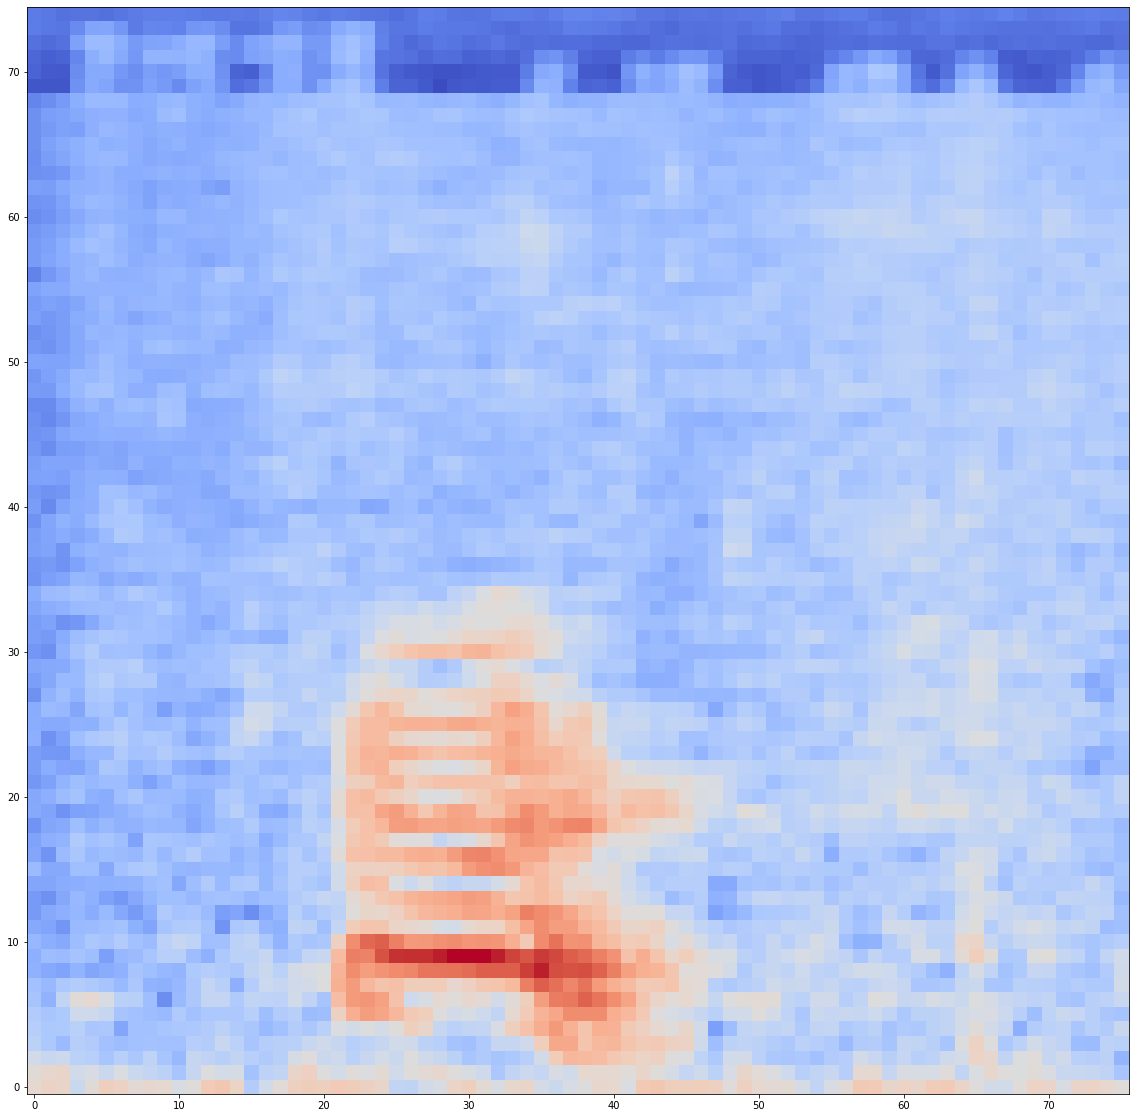

In [30]:
fig, ax = plt.subplots(figsize=(20,20))
mfcc_data= np.swapaxes(spect1, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
plt.show()

In [31]:
waveform2, audio_binary2 = get_waveform(path)

In [32]:
import random

In [33]:
spect2 = get_spectrogram(waveform2)

In [34]:
def spec_augment(spec: np.ndarray, num_mask=1, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.2):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.05, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.02, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        #Set band to 0
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.1, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        #Set band to 0
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [35]:
warped_masked_spectrogram = spec_augment(spect2.numpy())


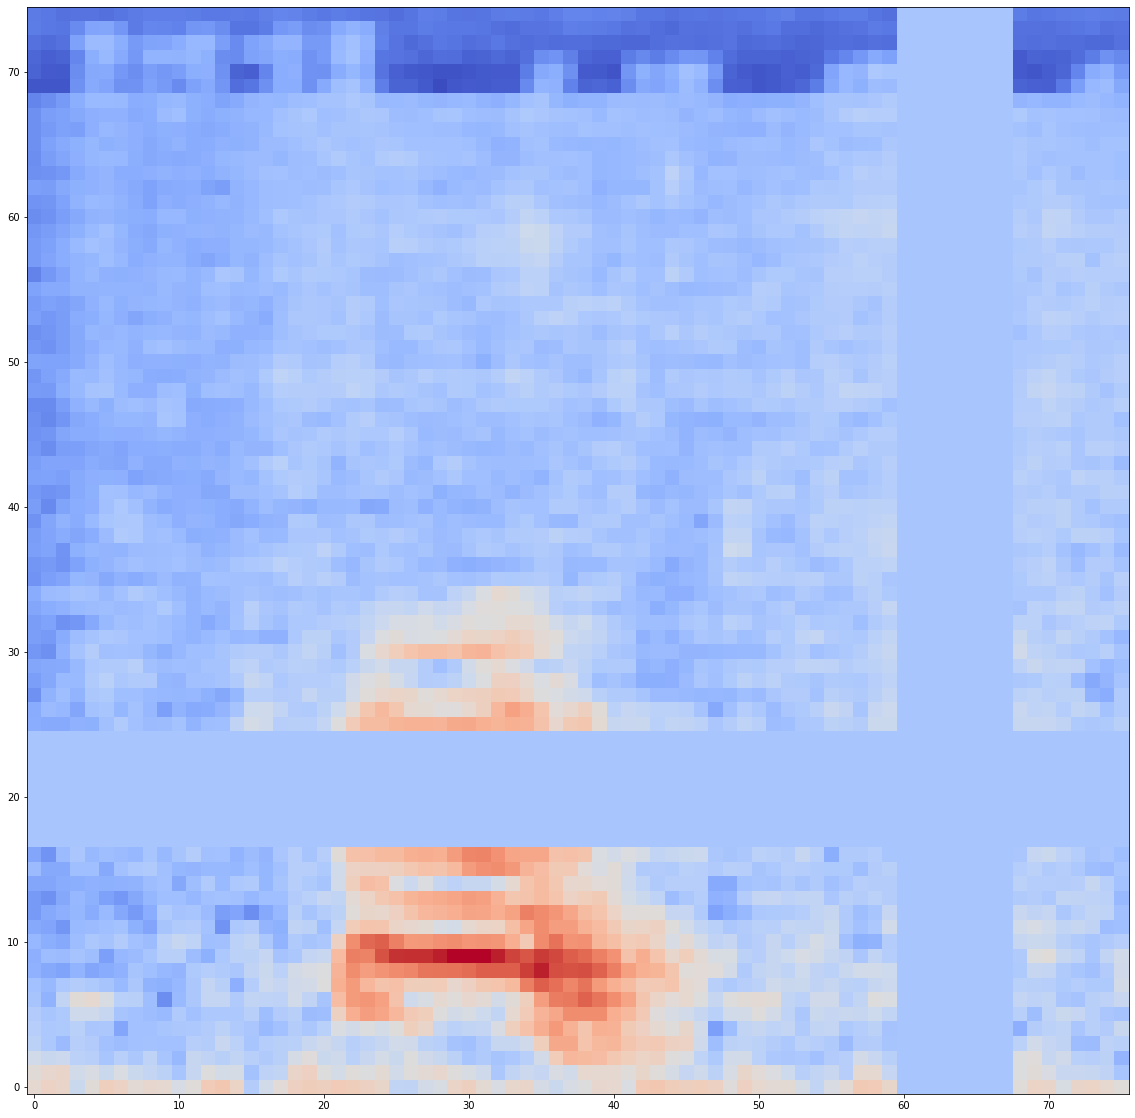

In [36]:
fig, ax = plt.subplots(figsize=(20,20))
mfcc_data= np.swapaxes(warped_masked_spectrogram, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
plt.show()